In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import groupby
import numpy as np
import re
import os

In [102]:
class Experiment:
    @staticmethod
    def _preprocess_csv(df):
        # Synchronicity problems cause some experiment
        # runs have periods that don't start at 0. So
        # the periods interval must be shifted so that
        # all experiment runs start at 0.
        df.index = df.index.map(lambda t: t - np.min(df.index))

        # Columns that are not relative to the CPU usage
        # of the device must be removed from the calculation
        # of the total CPU usage for each time step
        cols_drop = ['Stack', 'Mbps'] + (['main'] if 'main' in df.columns else [])
        total_cpu_usage = np.sum(df.drop(cols_drop, axis=1), axis=1)

        df['CPU'] = df['wifi'].values / total_cpu_usage 
        return df[['CPU', 'Stack', 'Mbps']]

    def __init__(self, name: str, directory: str, reps_file_names: str):
        self.name = name
        reps = ([pd.read_csv(f'{directory}/{file_name}', index_col='period') for file_name in reps_file_names])
        self.repetitions = [Experiment._preprocess_csv(rep) for rep in reps]

    def get_time_series(self, metric: str) -> np.array:
        return np.stack([rep[metric].values[:176] for rep in self.repetitions], axis=1)

In [103]:
class ExperimentsSuite:
    def __init__(self, data_dir: str):
        runs = os.listdir('./formated_data')
        exps_file_names = {exp_name: list(group) for exp_name, group in groupby(runs, key=lambda r: r[:-6])}
        self.experiments = {name: Experiment(name, data_dir, exps_file_names[name]) for name in exps_file_names}

    @staticmethod
    def _group_models(experiments):
        groups = {key: [] for key in set([experiment[2:] for experiment in experiments])} 
        for experiment in experiments:
            groups[experiment[2:]].append(experiment)
        return groups

    def plot_experiments(self, metric):
        colors = ['indianred', 'limegreen', 'royalblue', 'yellow']
        x_ticks = np.arange(0, 175, 25)
        groupped_models = ExperimentsSuite._group_models(self.experiments.keys())

        subplots = [plt.subplots(1, 1, figsize=(16, 9)) for _ in groupped_models]
        figs, axis = list(zip(*subplots))
        for ax, group in zip(axis, groupped_models):
            names, points = list(zip(*[(exp[:2], np.ravel(self.experiments[exp].get_time_series(metric))) for exp in groupped_models[group]]))
            violin_parts = ax.violinplot(points, list(range(len(points))), showmedians=True)
            for pc in violin_parts['bodies']:
                pc.set_facecolor('gray')
            violin_parts['cmedians'].set_facecolor('black')
            violin_parts['cmedians'].set_edgecolor('black')
            violin_parts['cbars'].set_facecolor('black')
            violin_parts['cbars'].set_edgecolor('black')
            violin_parts['cmins'].set_facecolor('black')
            violin_parts['cmins'].set_edgecolor('black')
            violin_parts['cmaxes'].set_facecolor('black')
            violin_parts['cmaxes'].set_edgecolor('black')
            ax.set_xticks(list(range(len(names))))
            ax.set_xticklabels(names)
            ax.set_xlabel('Models', fontsize=20)
            ax.set_ylabel(metric, fontsize=20, labelpad=10.0)
            ax.set_title(group, fontsize=30)
            ax.tick_params(axis='x', labelsize=15)
            ax.grid(color='gainsboro', linestyle=':', linewidth=2)
        return {name: fig for name, fig in zip(groupped_models, figs)}
    
    def get_factors_importance(self, model):
        levels = ['A0I1M0', 'A0I1M1', 'A0I2M0', 'A0I2M1', f'A{model}I1M0', f'A{model}I1M1', f'A{model}I2M0', f'A{model}I2M1']
        encoded_A_levels = np.array([-1, -1, -1, -1, 1, 1, 1, 1])
        encoded_I_levels = np.array([-1, -1, 1, 1, -1, -1, 1, 1])
        encoded_M_levels = np.array([1, -1, 1, -1, 1, -1, 1, -1])
        first_column = np.ones_like(encoded_I_levels)
        second_column = encoded_A_levels
        third_column = encoded_I_levels
        fourth_column = encoded_M_levels
        fith_column = encoded_A_levels * encoded_I_levels
        sixth_column = encoded_A_levels * encoded_M_levels
        seventh_column = encoded_I_levels * encoded_M_levels
        eigth_column = encoded_A_levels * encoded_I_levels * encoded_M_levels
        X = np.stack([first_column, second_column, third_column, fourth_column, fith_column, sixth_column, seventh_column, eigth_column], axis=1)
        
        cpu_series = np.array([self.experiments[level].get_time_series('CPU') for level in levels])
        cpu_vals = np.mean(cpu_series[:,150:,:], axis=1)
        mean_cpus = np.mean(cpu_vals, axis=-1)
        system_solutions = np.linalg.solve(X, mean_cpus)
        errors = cpu_vals - np.expand_dims(mean_cpus, axis=-1)
        squared_errors = np.square(errors)
        squared_system_solutions = np.square(system_solutions)
        squared_cpus = np.square(cpu_vals)
        SSY = np.sum(squared_cpus)
        SSE = np.sum(squared_errors)
        SSqs = 8 * 10 * squared_system_solutions
        SST = SSY - SSqs[0]
        
        importances = (np.concatenate([SSqs[1:], np.expand_dims(SSE, axis=0)]) / np.expand_dims(SST, axis=0)).T
        return importances

In [104]:
experiments_suite = ExperimentsSuite('./formated_data')

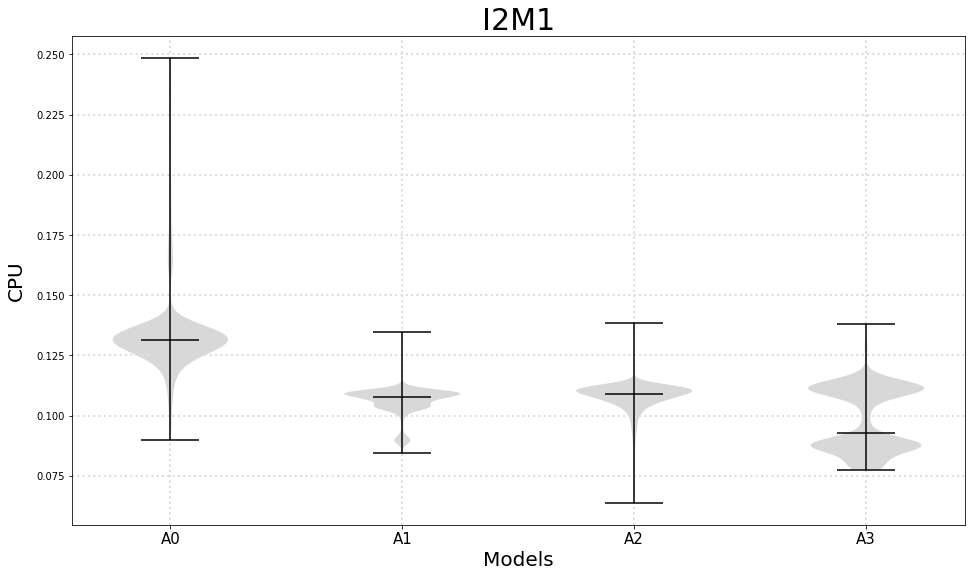

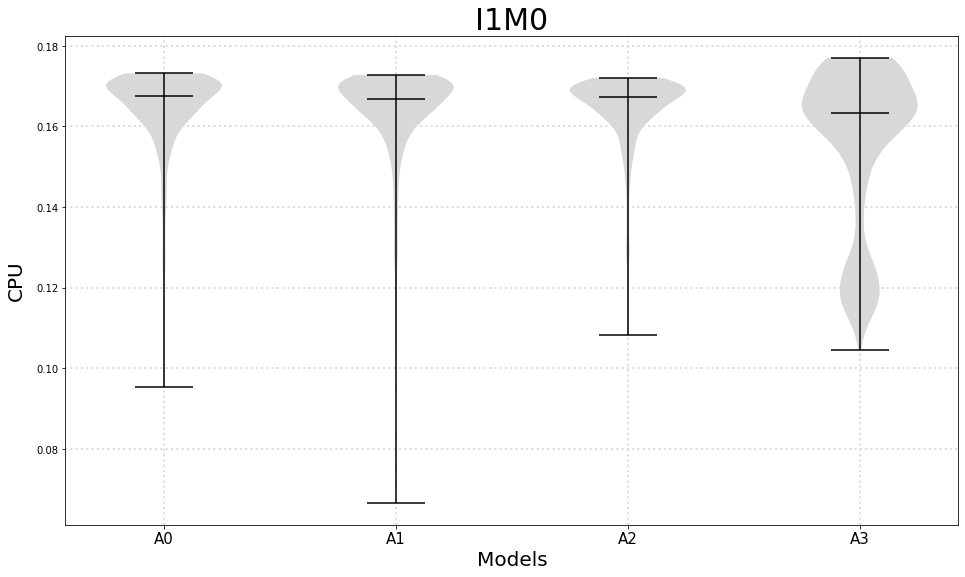

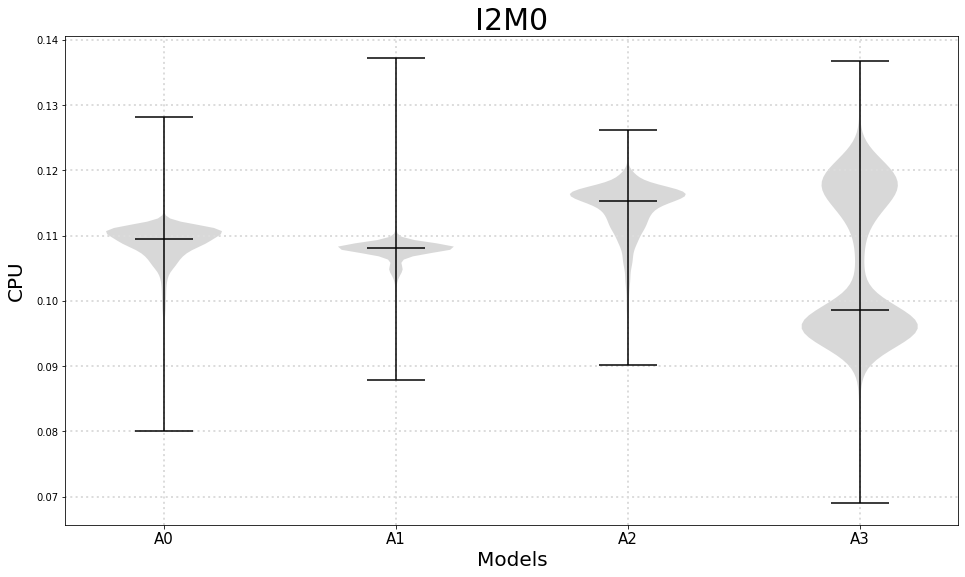

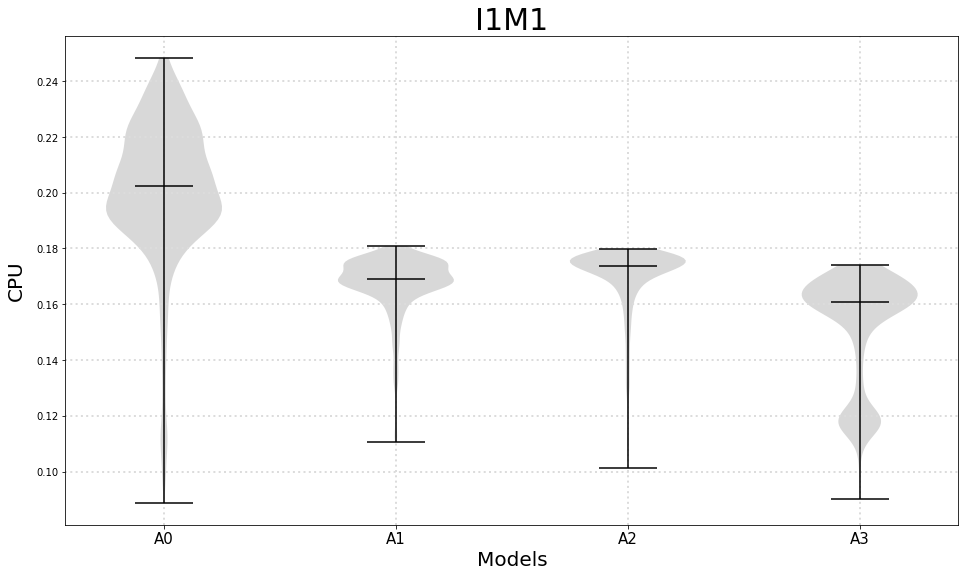

In [105]:
figs = experiments_suite.plot_experiments('CPU')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_wifi.pdf')

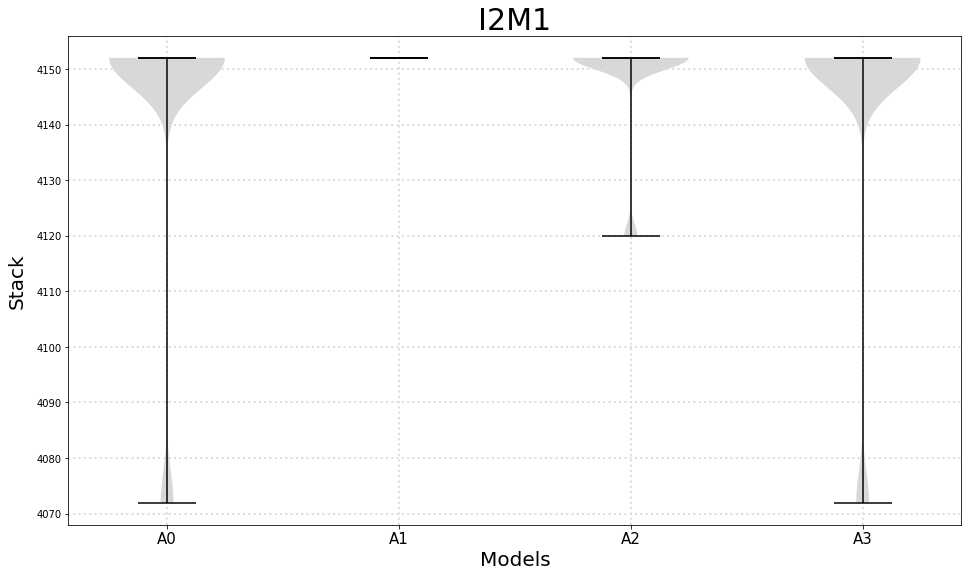

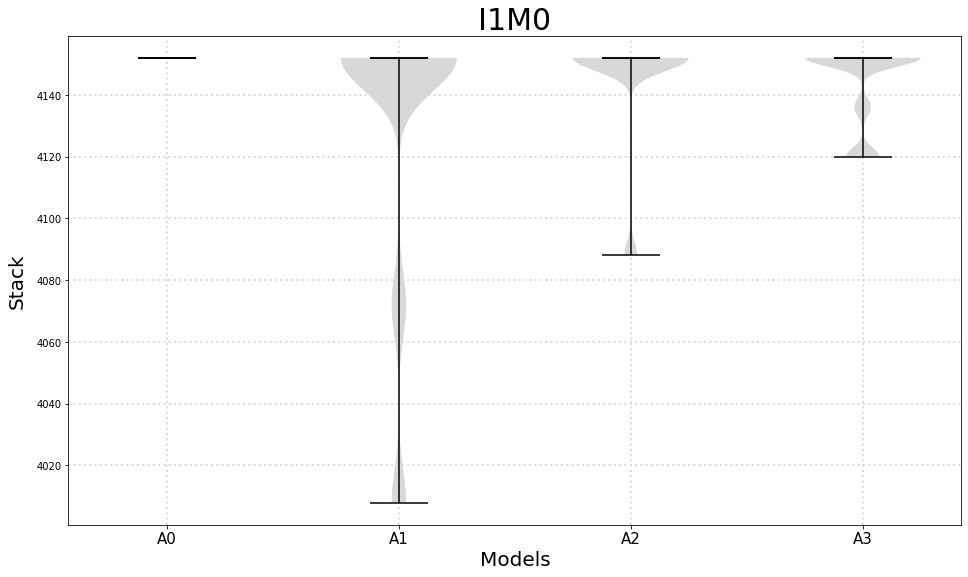

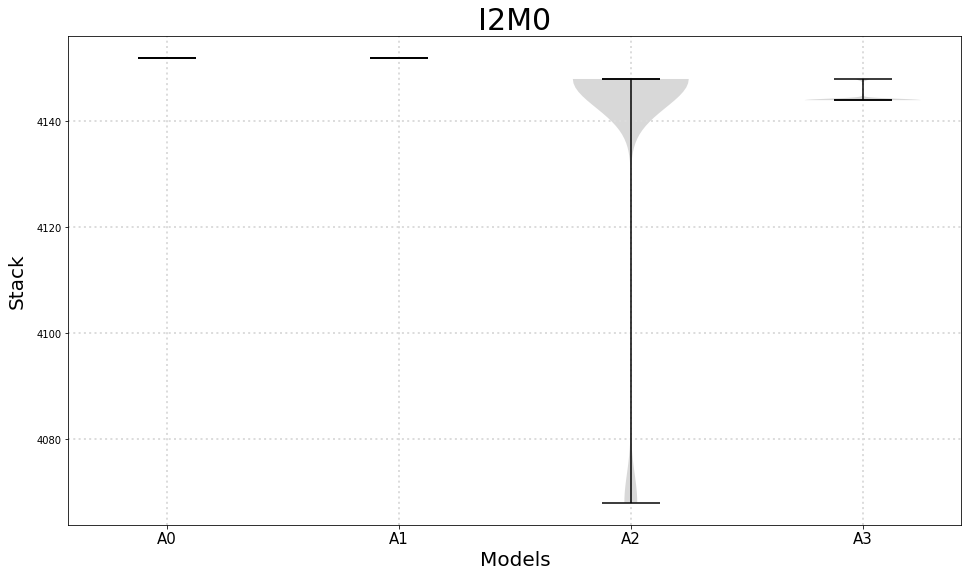

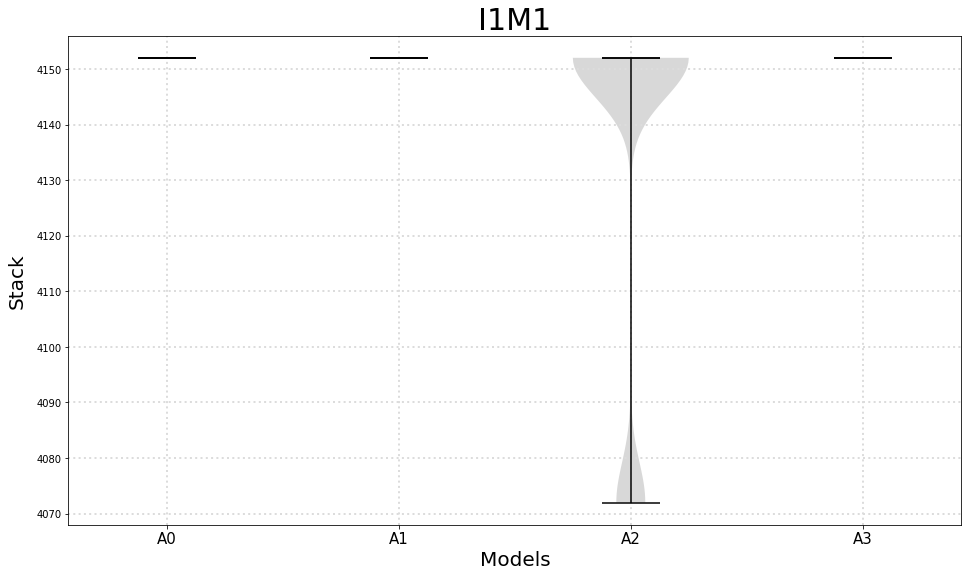

In [106]:
figs = experiments_suite.plot_experiments('Stack')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_stack.pdf')

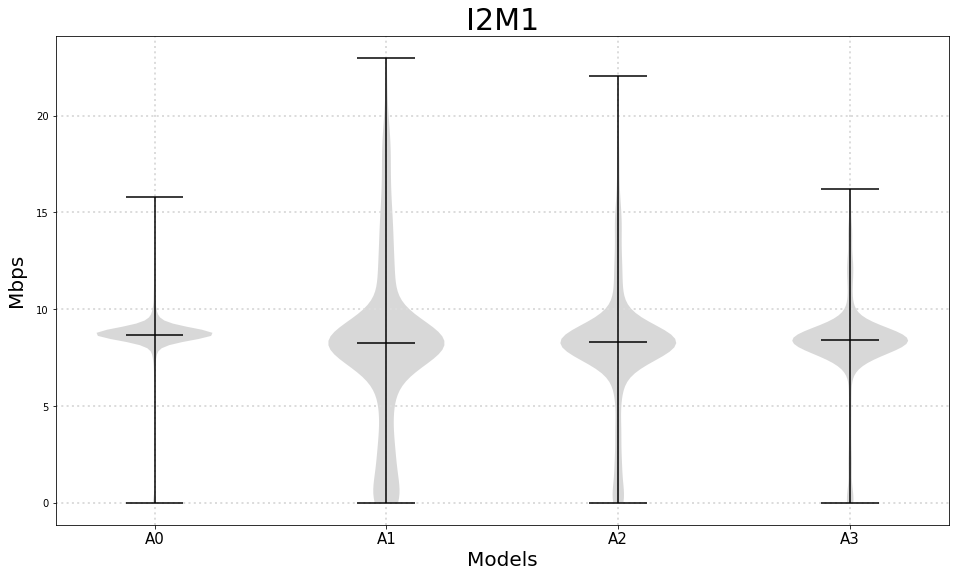

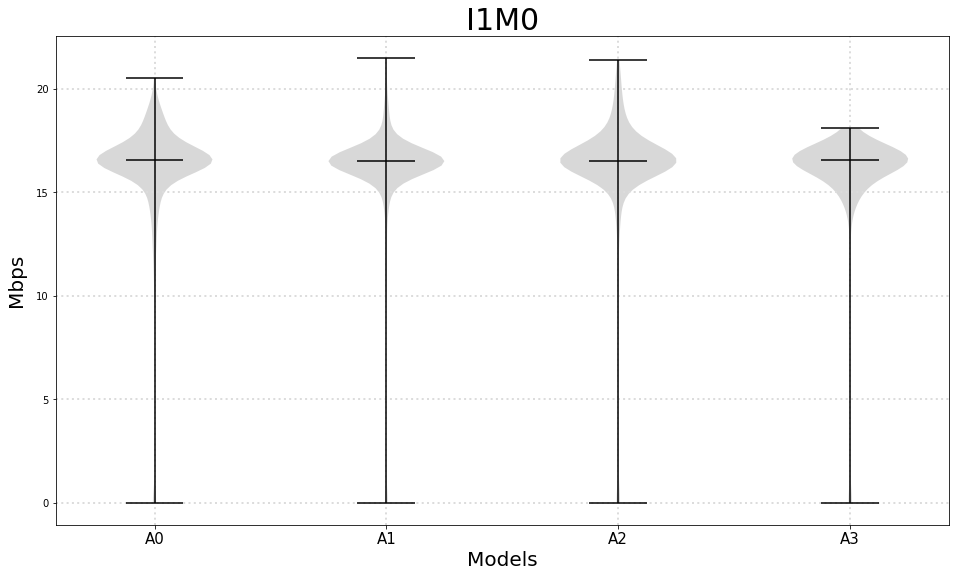

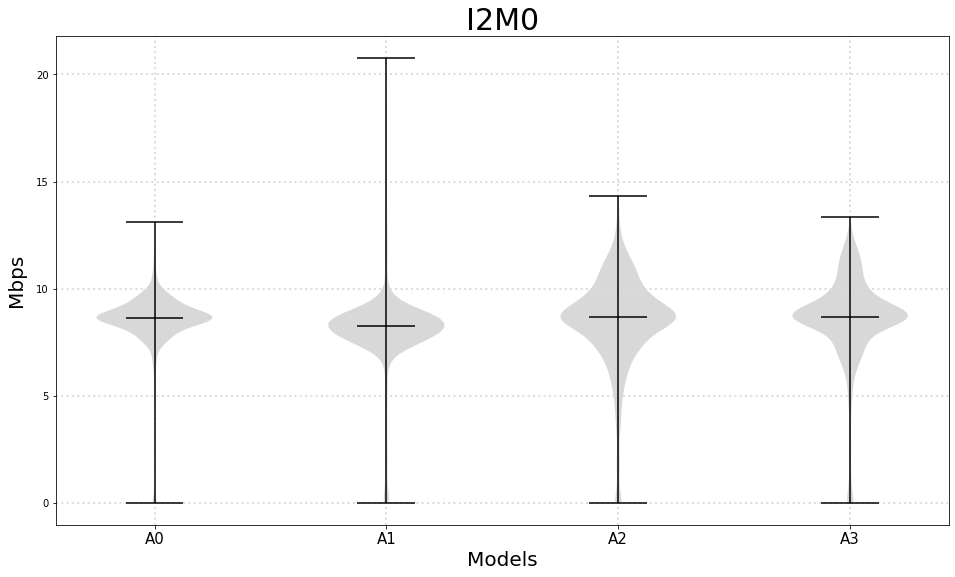

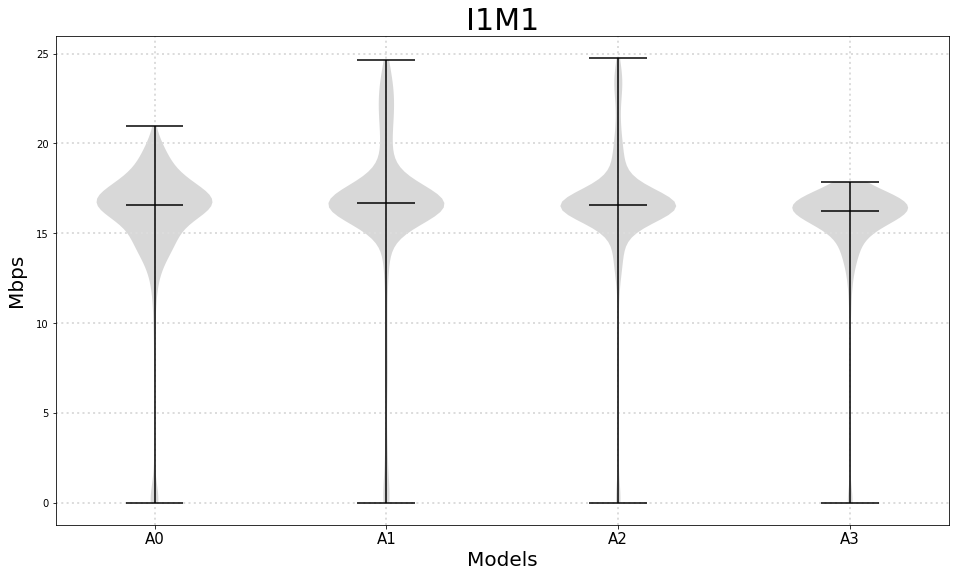

In [107]:
figs = experiments_suite.plot_experiments('Mbps')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_Mbps.pdf')

In [108]:
importances = np.array([experiments_suite.get_factors_importance(i) for i in range(1, 4)])

x = pd.DataFrame(importances, index=['A1', 'A2', 'A3'], columns=['A', 'I', 'M', 'AI', 'AM', 'IM', 'AIM', 'Err'])
x

,A,I,M,AI,AM,IM,AIM,Err
A1,0.046484,0.845839,0.047510,0.000024,0.036791,0.001581,2.583640e-06,0.021768
A2,0.029010,0.853490,0.049817,0.000639,0.040781,0.004747,6.749171e-04,0.020842
A3,0.129679,0.745791,0.026759,0.003554,0.062472,0.001714,1.243413e-07,0.030032


[[0.04648425 0.89232334 0.9398338  0.9398574  0.97664809 0.97822925
  0.97823184 1.        ]
 [0.02900967 0.88249934 0.93231602 0.93295539 0.97373602 0.97848339
  0.97915831 1.        ]
 [0.12967938 0.87547004 0.90222902 0.90578255 0.96825422 0.96996792
  0.96996804 1.        ]]


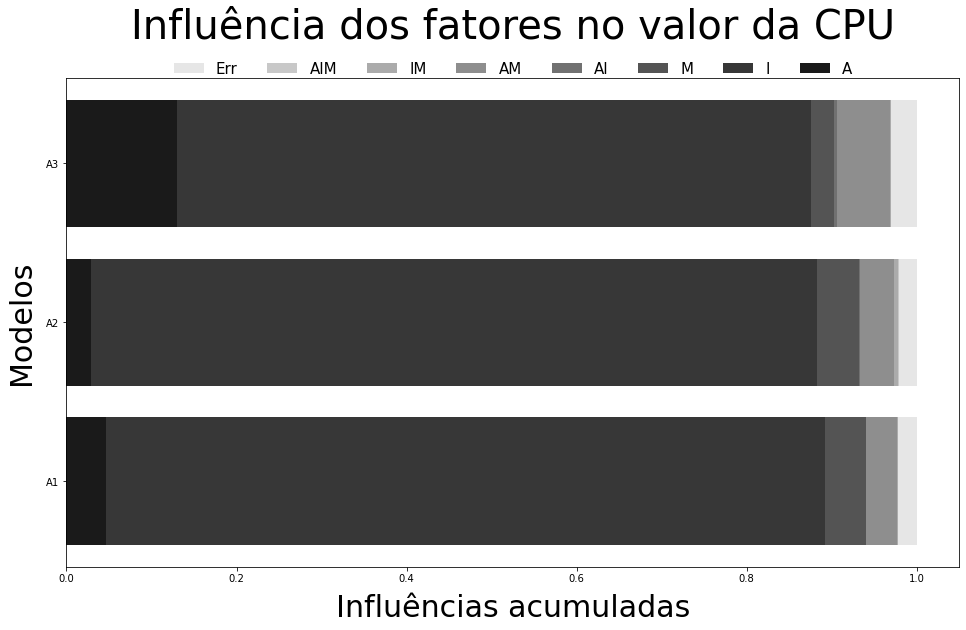

In [138]:
A = x['A']
I = A + x['I']
M = A + I + x['M']
AI = A + I + M + x['AI']
AM = A + I + M + + AI + x['AM']
IM = A + I + M + + AI + + AM + x['IM']
AIM = A + I + M + + AI + + AM + + IM + x['AIM']
fig, axis = plt.subplots(1, 1, figsize=(16, 9))
print(np.cumsum(x.values, axis=1))
colors = list(reversed(np.linspace(0.1, 0.9, 8)))
for i, (a, b) in enumerate(reversed(list(zip(np.cumsum(x.values, axis=1).T, ['A', 'I', 'M', 'AI', 'AM', 'IM', 'AIM', 'Err'])))):
    axis.barh(list(range(3)), a, color=(colors[i], colors[i], colors[i]), alpha=1)
    axis.set_yticks(list(range(3)))
    axis.set_yticklabels(['A1', 'A2', 'A3'])
axis.legend()

axis.set_xlabel('Influências acumuladas', fontsize=30, labelpad=10)
axis.set_ylabel('Modelos', fontsize=30, labelpad=10)
axis.set_title('Influência dos fatores no valor da CPU', fontsize=40, pad=40)
axis.legend(['A', 'I', 'M', 'AI', 'AM', 'IM', 'AIM', 'Err'], ncols=8, loc='upper center', fontsize=15, borderaxespad=-1.5, frameon=False)
fig.savefig(f'./graphs/factors_influence.pdf')